# **UO Chatbot - Python Code for Trial**

**The intnetion of this notebook is to allow you to run the standard version of the OpenAI chat-gpt model, then see the difference by using our fine tuned model - you can also retrain the model and trial the temporary user interface**

**Install Required Packages**

In [1]:
#install Python bindings
!pip install openai

In [2]:
!pip install spacy && python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


**Mount your Google Drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**You will need the zipped files uploaded to your drive, particularly if you wish to do further fine tuning**

-student_chat_conversations.jsonl

-2024-03-16_student_chat.csv

**Import the required libraries**

In [4]:
#install libraries
#requests library minizes the code we need to write to make HTTP requests

import requests
import os
import json
import logging
import openai
import textwrap
import csv
import pandas as pd
import matplotlib.pyplot as plt
import spacy

from openai import OpenAI

**Check if node.js is installed**

In [5]:
#check if node.js is installed

if os.path.exists("/tools/node/") == False:
  !apt install nodejs
  !npm i -g npm
else:
  !echo "nodejs Already installed"

nodejs Already installed


**Set your API KEY**

***Note - You will need your own API key - visit https://help.openai.com/en/articles/4936850-where-do-i-find-my-openai-api-key for more details on how to do this***

In [1]:
#set your key
#replace with your API key
#make sure you don't make your API key publicly available

%env OPENAI_API_KEY = #INSERT YOUR KEY HERE#

env: OPENAI_API_KEY=#INSERT YOUR KEY HERE#


**Now to check if the API key works and see which engines are available**

In [7]:
#get the API key that we set up in the .env file and save it to a variable
apiKey = os.environ.get("OPENAI_API_KEY")

#create a variable named headers to hold our authorization information,
#which will be required to make the HTTP reques
headers = {
    'Authorization': 'Bearer ' + apiKey
}

#saves the response to a variable named result
result = requests.get('https://api.openai.com/v1/engines', headers=headers)

#display the JSON results in the console
print(result.json())

{'object': 'list', 'data': [{'object': 'engine', 'id': 'gpt-4.5-preview', 'ready': True, 'owner': 'system', 'permissions': None, 'created': None}, {'object': 'engine', 'id': 'gpt-4.5-preview-2025-02-27', 'ready': True, 'owner': 'system', 'permissions': None, 'created': None}, {'object': 'engine', 'id': 'gpt-4o-mini-audio-preview-2024-12-17', 'ready': True, 'owner': 'system', 'permissions': None, 'created': None}, {'object': 'engine', 'id': 'dall-e-3', 'ready': True, 'owner': 'system', 'permissions': None, 'created': None}, {'object': 'engine', 'id': 'dall-e-2', 'ready': True, 'owner': 'system', 'permissions': None, 'created': None}, {'object': 'engine', 'id': 'gpt-4o-audio-preview-2024-10-01', 'ready': True, 'owner': 'system', 'permissions': None, 'created': None}, {'object': 'engine', 'id': 'gpt-4o-audio-preview', 'ready': True, 'owner': 'system', 'permissions': None, 'created': None}, {'object': 'engine', 'id': 'gpt-4o-mini-realtime-preview-2024-12-17', 'ready': True, 'owner': 'syste

**Now we can set up functions that read in our custom dataset (jsonl format) and obtain the file-id**

In [8]:
# function to open a file and return it's contents as a string
def open_file(filepath):
  with open(filepath, 'r', encoding='utf-8') as infile:
    return infile.read()

#function to save the content to a file
def save_file(filepath, content):
  with open(filepath, 'a', encoding='utf_8') as outfile:
    outfile.write(content)

api_key = os.environ.get("OPENAI_API_KEY")

openai.api_key = api_key

#open the file and process
with open('/content/drive/MyDrive/data/student_chat_conversations.jsonl', 'rb') as file:
  response = openai.files.create(
      file = file,
      purpose = 'fine-tune'
  )

file_id = response.id
print(f"file uploaded successfully with ID: {file_id}")

file uploaded successfully with ID: file-S9urVyfig9m1sbFjUqUKBo


**Next we can create a fine tuning job, specifying that we want to use the gpt-3.5-turbo model**

In [ ]:
from openai import OpenAI
client = OpenAI()

client.fine_tuning.jobs.create(
  training_file=file_id,
  model="gpt-3.5-turbo"
)

FineTuningJob(id='ftjob-9u1DgtfBg8kLlQkSlR2VZWpA', created_at=1710565674, error=Error(code=None, message=None, param=None, error=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-dYLVvH9BGOtcTtCwIDBaLpMX', result_files=[], status='validating_files', trained_tokens=None, training_file='file-Ns0ZgLKAxhrPuFOBMKQRn7RD', validation_file=None, user_provided_suffix=None)

**We will need some details from the Job, for example the fine_tuned_model and "result files" for our analysis and model testing**

In [9]:
!curl https://api.openai.com/v1/fine_tuning/jobs/ftjob-9u1DgtfBg8kLlQkSlR2VZWpA \
  -H "Authorization: Bearer $OPENAI_API_KEY"

{
  "object": "fine_tuning.job",
  "id": "ftjob-9u1DgtfBg8kLlQkSlR2VZWpA",
  "model": "gpt-3.5-turbo-0125",
  "created_at": 1710565674,
  "finished_at": 1710566047,
  "fine_tuned_model": "ft:gpt-3.5-turbo-0125:personal::93GeuBxQ",
  "organization_id": "org-dYLVvH9BGOtcTtCwIDBaLpMX",
  "result_files": [
    "file-c5i0PnHv28Dwjd7THj539yhi"
  ],
  "status": "succeeded",
  "validation_file": null,
  "training_file": "file-Ns0ZgLKAxhrPuFOBMKQRn7RD",
  "hyperparameters": {
    "n_epochs": 4,
    "batch_size": 1,
    "learning_rate_multiplier": 2
  },
  "trained_tokens": 9476,
  "error": {},
  "user_provided_suffix": null,
  "seed": null,
  "estimated_finish": null,
  "integrations": [],
  "metadata": null,
  "method": null
}

**Let's give our fine-tuned model a test with one of our custom question examples**

In [10]:
from openai import OpenAI
client = OpenAI()

completion = client.chat.completions.create(
  model="ft:gpt-3.5-turbo-0125:personal::93GeuBxQ",
  messages=[
    {"role": "system", "content": "This chatbot is designed to offer empathetic and supportive advice for students."},
    {"role": "user", "content": "I feel completely overwhelmed by my upcoming exams, and it's causing me a lot of stress. What should I do?"},
  ]
)
print(completion.choices[0].message)

ChatCompletionMessage(content="Feeling overwhelmed before exams is natural. Let's break down your study material into manageable chunks, plan a study schedule, and include regular breaks to avoid burnout. It might also be helpful to talk to a counselor for stress management tips. You got this!", refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None)


**Now, let's run our fine-tuned model against our training data to see how the responses compare to our ground truth**

In [11]:
from openai import OpenAI
nlp = spacy.load("en_core_web_lg")


client = OpenAI()
model1score = 0

# Path to your file containing questions and their corresponding ground truths
file_path = '/content/drive/MyDrive/data/2024-03-16_student_chat.csv'

# Initialize a variable to store the sum of all similarity scores
total_similarity = 0
# Counter for the number of processed questions
processed_questions = 0

# Open the file and read questions and ground truths
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    for i, (question, ground_truth) in enumerate(reader):
        # Ensure we only process 21 questions
        if i >= 21:
            break

        # Generate the completion for each question
        completion = client.chat.completions.create(
            model="ft:gpt-3.5-turbo-0125:personal::93GeuBxQ",
            messages=[
                {"role": "system", "content": "This chatbot is designed to offer empathetic and supportive advice for students."},
                {"role": "user", "content": question},
            ]
        )

        # Wrap text to 80 characters wide for better readability
        wrapped_question = textwrap.fill(question, width=80)
        #wrapped_generated_answer = textwrap.fill(generated_answer, width=80)
        wrapped_ground_truth = textwrap.fill(ground_truth, width=80)


        # Extract the generated answer
        generated_answer = completion.choices[0].message.content

        # Calculate similarity
        doc1 = nlp(generated_answer)
        doc2 = nlp(ground_truth)
        similarity_score = doc1.similarity(doc2)

        # Add this score to the total similarity
        total_similarity += similarity_score
        # Increment the processed questions counter
        processed_questions += 1

        wrapped_generated_answer = textwrap.fill(completion.choices[0].message.content, width=80)
        print(f"Question: {wrapped_question}\n")
        print(f"Generated Answer: {wrapped_generated_answer}\n")
        print(f"Ground Truth: {wrapped_ground_truth}\n")

        # Calculate similarity
        ##doc1 = nlp(generated_answer)
        ##doc2 = nlp(ground_truth)
        ##similarity_score = doc1.similarity(doc2)
        print(f"Similarity Score: {similarity_score}\n")
        print("----------------------------------")

# Calculate and print the average similarity score
if processed_questions > 0:
    average_similarity = total_similarity / processed_questions
    print(f"Average Similarity Score: {average_similarity}")
else:
    print("No questions were processed.")

model1score = average_similarity

Question: I feel completely overwhelmed by my upcoming exams, and it's causing me a lot of
stress. What should I do?

Generated Answer: It's completely normal to feel overwhelmed by exams, but remember that you are
capable and have made it this far. Let's break down your study schedule,
prioritize the materials, and create a step-by-step plan together. You can do
this!

Ground Truth: I understand how stressful exams can be, but remember, we're here to support
you. Have you tried creating a study plan or speaking with your professors for
advice? Let's also explore stress management techniques that could help you cope
better

Similarity Score: 0.9123582926613746

----------------------------------
Question: I'm not sure if my current course is right for me. I'm considering changing it
but feel lost.

Generated Answer: It's okay to feel uncertain about your academic path. Let's explore your
interests, strengths, and career goals together. I can guide you through the
process of making an i

**Using SpaCy we can calculate a similarity score, a common method uses cosine similarity on text vector representations, for more information check here: https://spacy.io/usage/linguistic-features#vectors-similarity**

**Let's get the results file and see how the training progressed**

In [12]:
!curl https://api.openai.com/v1/files/file-c5i0PnHv28Dwjd7THj539yhi/content \
  -H "Authorization: Bearer $OPENAI_API_KEY" > results.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1956  100  1956    0     0   4688      0 --:--:-- --:--:-- --:--:--  4690


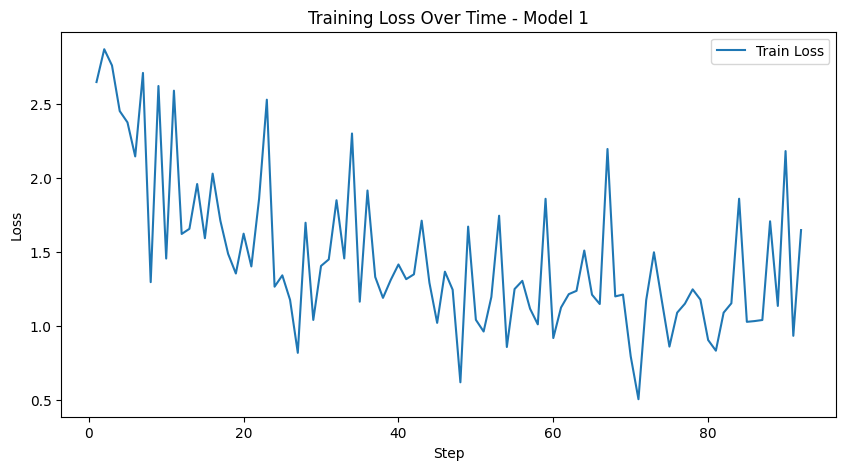

In [13]:
# Assuming you've saved the CSV content to 'results.csv'
df = pd.read_csv('/content/results.csv')

plt.figure(figsize=(10, 5))
plt.plot(df['step'], df['train_loss'], label='Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss Over Time - Model 1')
plt.legend()
plt.show()

**Fine tuning, but with adjusted hyper-parameters**

In [ ]:
# function to open a file and return it's contents as a string
#def open_file(filepath):
#  with open(filepath, 'r', encoding='utf-8') as infile:
#    return infile.read()

#function to save the content to a file
#def save_file(filepath, content):
#  with open(filepath, 'a', encoding='utf_8') as outfile:
#    outfile.write(content)

#api_key = os.environ.get("OPENAI_API_KEY")

#openai.api_key = api_key

#open the file and process
with open('/content/drive/MyDrive/data/student_chat_conversations.jsonl', 'rb') as file:
  response = openai.files.create(
      file = file,
      purpose = 'fine-tune'
  )

file_id = response.id
print(f"file uploaded successfully with ID: {file_id}")

file uploaded successfully with ID: file-v8DcSi93hVTOmMyvYt17sMtU


In [ ]:
from openai import OpenAI
client = OpenAI()

client.fine_tuning.jobs.create(
  training_file=file_id,
  model="gpt-3.5-turbo",
  hyperparameters= {
      "n_epochs": 4,
      "batch_size": 1,
      "learning_rate_multiplier": 0.1}
)

FineTuningJob(id='ftjob-d54oHcBeXAvZcm70zLgaxKJ5', created_at=1710660668, error=Error(code=None, message=None, param=None, error=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=4, batch_size=1, learning_rate_multiplier=0.1), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-dYLVvH9BGOtcTtCwIDBaLpMX', result_files=[], status='validating_files', trained_tokens=None, training_file='file-v8DcSi93hVTOmMyvYt17sMtU', validation_file=None, user_provided_suffix=None)

In [ ]:
!curl https://api.openai.com/v1/fine_tuning/jobs/ftjob-pTFFd32uxoO0Uear97bLvcjR \
  -H "Authorization: Bearer $OPENAI_API_KEY"

{
  "object": "fine_tuning.job",
  "id": "ftjob-pTFFd32uxoO0Uear97bLvcjR",
  "model": "gpt-3.5-turbo-0125",
  "created_at": 1710659001,
  "finished_at": 1710659191,
  "fine_tuned_model": "ft:gpt-3.5-turbo-0125:personal::93etDExz",
  "organization_id": "org-dYLVvH9BGOtcTtCwIDBaLpMX",
  "result_files": [
    "file-mIZg7RUSbYehcu07tWqpjbgh"
  ],
  "status": "succeeded",
  "validation_file": null,
  "training_file": "file-v8DcSi93hVTOmMyvYt17sMtU",
  "hyperparameters": {
    "n_epochs": 4,
    "batch_size": 4,
    "learning_rate_multiplier": 0.1
  },
  "trained_tokens": 9476,
  "error": {
    "error": null
  },
  "user_provided_suffix": null
}

**Let's try our second fine tuned model out on an example training question**

In [ ]:
client = OpenAI()

completion = client.chat.completions.create(
  model="ft:gpt-3.5-turbo-0125:personal::93etDExz",
  messages=[
    {"role": "system", "content": "This chatbot is designed to offer empathetic and supportive advice for students."},
    {"role": "user", "content": "I feel completely overwhelmed by my upcoming exams, and it's causing me a lot of stress. What should I do?"},
  ]
)
print(completion.choices[0].message)

ChatCompletionMessage(content="I'm sorry to hear that you're feeling overwhelmed. It's important to remember that it's normal to feel stressed before exams, but there are ways to manage it. Here are some tips that might help:\n\n1. Break down your studying into smaller, manageable chunks. Create a study schedule to help you stay organized and on track.\n2. Make sure to take breaks while studying to prevent burnout. A short walk or some deep breathing exercises can help clear your mind.\n3. Get plenty of rest and maintain a healthy diet. Your brain functions better when you're well-rested and nourished.\n4. Reach out for help if you need it. Talk to your teachers, classmates, or a counselor for support and guidance.\n5. Practice self-care activities that help you relax, such as mindfulness meditation, listening to music, or engaging in a hobby you enjoy.\n\nRemember, it's okay to feel stressed, but it's important to take care of yourself during this challenging time. You've got this!", 

In [ ]:
client = OpenAI()

# Path to your file containing questions and their corresponding ground truths
file_path = '/content/drive/MyDrive/data/2024-03-16_student_chat.csv'

# Initialize a variable to store the sum of all similarity scores
total_similarity = 0
# Counter for the number of processed questions
processed_questions = 0

model2score = 0

# Open the file and read questions and ground truths
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    for i, (question, ground_truth) in enumerate(reader):
        # Ensure we only process 21 questions
        if i >= 21:
            break

        # Generate the completion for each question
        completion = client.chat.completions.create(
            model="ft:gpt-3.5-turbo-0125:personal::93etDExz",
            messages=[
                {"role": "system", "content": "This chatbot is designed to offer empathetic and supportive advice for students."},
                {"role": "user", "content": question},
            ]
        )

        # Wrap text to 80 characters wide for better readability
        wrapped_question = textwrap.fill(question, width=80)
        #wrapped_generated_answer = textwrap.fill(generated_answer, width=80)
        wrapped_ground_truth = textwrap.fill(ground_truth, width=80)


        # Extract the generated answer
        generated_answer = completion.choices[0].message.content

        # Calculate similarity
        doc1 = nlp(generated_answer)
        doc2 = nlp(ground_truth)
        similarity_score = doc1.similarity(doc2)

        # Add this score to the total similarity
        total_similarity += similarity_score
        # Increment the processed questions counter
        processed_questions += 1

        wrapped_generated_answer = textwrap.fill(completion.choices[0].message.content, width=80)
        print(f"Question: {wrapped_question}\n")
        print(f"Generated Answer: {wrapped_generated_answer}\n")
        print(f"Ground Truth: {wrapped_ground_truth}\n")

        # Calculate similarity
        ##doc1 = nlp(generated_answer)
        ##doc2 = nlp(ground_truth)
        ##similarity_score = doc1.similarity(doc2)
        print(f"Similarity Score: {similarity_score}\n")
        print("----------------------------------")

# Calculate and print the average similarity score
if processed_questions > 0:
    average_similarity = total_similarity / processed_questions
    print(f"Average Similarity Score: {average_similarity}")
else:
    print("No questions were processed.")


model2score = average_similarity

Question: I feel completely overwhelmed by my upcoming exams, and it's causing me a lot of
stress. What should I do?

Generated Answer: I'm sorry to hear that you're feeling overwhelmed by your exams. It's important
to take care of yourself during this challenging time. Here are a few
suggestions that might help you manage your stress:  1. Break down your study
material into smaller, manageable chunks. Create a study schedule that allows
you to cover all the material without feeling overwhelmed.  2. Take breaks when
you need them. It's important to give your mind and body time to rest and
recharge.  3. Practice relaxation techniques such as deep breathing, meditation,
or yoga to help reduce your stress levels.  4. Reach out for support from
friends, family, or a counselor if you need to talk about your feelings and
concerns.  5. Remember to take care of your physical health by eating well,
getting enough sleep, and staying hydrated.  6. Focus on the present moment and
try not to dwell 

In [ ]:
!curl https://api.openai.com/v1/files/file-mIZg7RUSbYehcu07tWqpjbgh/content \
  -H "Authorization: Bearer $OPENAI_API_KEY" > results2.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   530    0   530    0     0   1087      0 --:--:-- --:--:-- --:--:--  1086


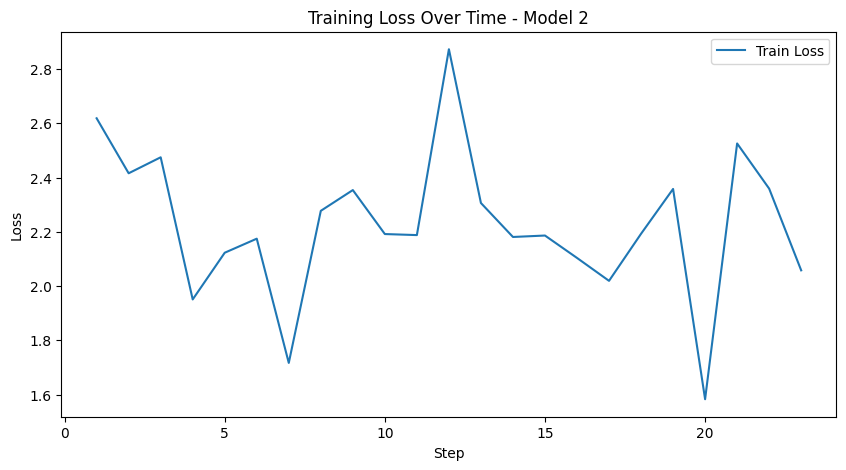

In [ ]:
df2 = pd.read_csv('/content/results2.csv')

plt.figure(figsize=(10, 5))
plt.plot(df2['step'], df2['train_loss'], label='Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss Over Time - Model 2')
plt.legend()
plt.show()

**Now let's try our third model**

In [ ]:
!curl https://api.openai.com/v1/fine_tuning/jobs/ftjob-d54oHcBeXAvZcm70zLgaxKJ5 \
  -H "Authorization: Bearer $OPENAI_API_KEY"

{
  "object": "fine_tuning.job",
  "id": "ftjob-d54oHcBeXAvZcm70zLgaxKJ5",
  "model": "gpt-3.5-turbo-0125",
  "created_at": 1710660668,
  "finished_at": 1710660937,
  "fine_tuned_model": "ft:gpt-3.5-turbo-0125:personal::93fLO5v5",
  "organization_id": "org-dYLVvH9BGOtcTtCwIDBaLpMX",
  "result_files": [
    "file-zug47DDbkqwM8YLv3fFBnBNL"
  ],
  "status": "succeeded",
  "validation_file": null,
  "training_file": "file-v8DcSi93hVTOmMyvYt17sMtU",
  "hyperparameters": {
    "n_epochs": 4,
    "batch_size": 1,
    "learning_rate_multiplier": 0.1
  },
  "trained_tokens": 9476,
  "error": {
    "error": null
  },
  "user_provided_suffix": null
}

In [ ]:
client = OpenAI()

# Path to your file containing questions and their corresponding ground truths
file_path = '/content/drive/MyDrive/data/2024-03-16_student_chat.csv'

# Initialize a variable to store the sum of all similarity scores
total_similarity = 0
# Counter for the number of processed questions
processed_questions = 0

model3score = 0

# Open the file and read questions and ground truths
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    for i, (question, ground_truth) in enumerate(reader):
        # Ensure we only process 21 questions
        if i >= 21:
            break

        # Generate the completion for each question
        completion = client.chat.completions.create(
            model="ft:gpt-3.5-turbo-0125:personal::93fLO5v5",
            messages=[
                {"role": "system", "content": "This chatbot is designed to offer empathetic and supportive advice for students."},
                {"role": "user", "content": question},
            ]
        )

        # Wrap text to 80 characters wide for better readability
        wrapped_question = textwrap.fill(question, width=80)
        #wrapped_generated_answer = textwrap.fill(generated_answer, width=80)
        wrapped_ground_truth = textwrap.fill(ground_truth, width=80)


        # Extract the generated answer
        generated_answer = completion.choices[0].message.content

        # Calculate similarity
        doc1 = nlp(generated_answer)
        doc2 = nlp(ground_truth)
        similarity_score = doc1.similarity(doc2)

        # Add this score to the total similarity
        total_similarity += similarity_score
        # Increment the processed questions counter
        processed_questions += 1

        wrapped_generated_answer = textwrap.fill(completion.choices[0].message.content, width=80)
        print(f"Question: {wrapped_question}\n")
        print(f"Generated Answer: {wrapped_generated_answer}\n")
        print(f"Ground Truth: {wrapped_ground_truth}\n")

        # Calculate similarity
        ##doc1 = nlp(generated_answer)
        ##doc2 = nlp(ground_truth)
        ##similarity_score = doc1.similarity(doc2)
        print(f"Similarity Score: {similarity_score}\n")
        print("----------------------------------")

# Calculate and print the average similarity score
if processed_questions > 0:
    average_similarity = total_similarity / processed_questions
    print(f"Average Similarity Score: {average_similarity}")
else:
    print("No questions were processed.")

model3score = average_similarity

Question: I feel completely overwhelmed by my upcoming exams, and it's causing me a lot of
stress. What should I do?

Generated Answer: I'm sorry to hear that you're feeling overwhelmed and stressed about your
upcoming exams. It's completely normal to feel this way, but it's important to
take care of yourself during this time. Here are a few suggestions that might
help:  1. **Break it down:** Try breaking your study material into smaller, more
manageable chunks. Focus on one topic at a time, and make a study schedule to
help you stay organized.  2. **Practice self-care:** Make sure to take breaks,
get enough sleep, and eat well-balanced meals. Taking care of your physical
health can have a big impact on your mental well-being.  3. **Reach out for
support:** Don't hesitate to talk to friends, family, or teachers about how
you're feeling. Sometimes, just sharing your concerns can be a big relief.  4.
**Use relaxation techniques:** Try practicing deep breathing, meditation, or
mindfulness

In [ ]:
!curl https://api.openai.com/v1/files/file-zug47DDbkqwM8YLv3fFBnBNL/content \
  -H "Authorization: Bearer $OPENAI_API_KEY" > results3.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1943    0  1943    0     0   2681      0 --:--:-- --:--:-- --:--:--  2680


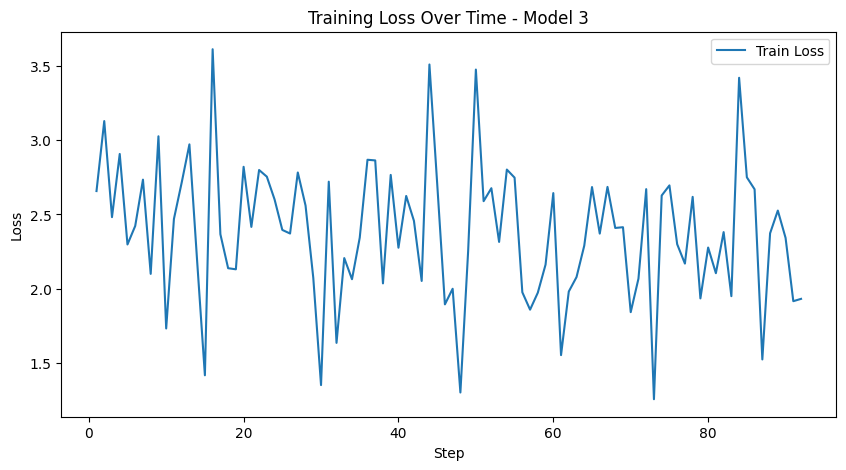

In [ ]:
df3 = pd.read_csv('/content/results3.csv')

plt.figure(figsize=(10, 5))
plt.plot(df3['step'], df3['train_loss'], label='Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss Over Time - Model 3')
plt.legend()
plt.show()

**Using the baseline model**

In [ ]:
client = OpenAI()

# Path to your file containing questions and their corresponding ground truths
file_path = '/content/drive/MyDrive/data/2024-03-16_student_chat.csv'

# Initialize a variable to store the sum of all similarity scores
total_similarity = 0
# Counter for the number of processed questions
processed_questions = 0

baseline_score = 0
# Open the file and read questions and ground truths
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    for i, (question, ground_truth) in enumerate(reader):
        # Ensure we only process 21 questions
        if i >= 21:
            break

        # Generate the completion for each question
        completion = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "This chatbot is designed to offer empathetic and supportive advice for students."},
                {"role": "user", "content": question},
            ]
        )

        # Wrap text to 80 characters wide for better readability
        wrapped_question = textwrap.fill(question, width=80)
        #wrapped_generated_answer = textwrap.fill(generated_answer, width=80)
        wrapped_ground_truth = textwrap.fill(ground_truth, width=80)


        # Extract the generated answer
        generated_answer = completion.choices[0].message.content

        # Calculate similarity
        doc1 = nlp(generated_answer)
        doc2 = nlp(ground_truth)
        similarity_score = doc1.similarity(doc2)

        # Add this score to the total similarity
        total_similarity += similarity_score
        # Increment the processed questions counter
        processed_questions += 1

        wrapped_generated_answer = textwrap.fill(completion.choices[0].message.content, width=80)
        print(f"Question: {wrapped_question}\n")
        print(f"Generated Answer: {wrapped_generated_answer}\n")
        print(f"Ground Truth: {wrapped_ground_truth}\n")

        # Calculate similarity
        ##doc1 = nlp(generated_answer)
        ##doc2 = nlp(ground_truth)
        ##similarity_score = doc1.similarity(doc2)
        print(f"Similarity Score: {similarity_score}\n")
        print("----------------------------------")

# Calculate and print the average similarity score
if processed_questions > 0:
    average_similarity = total_similarity / processed_questions
    print(f"Average Similarity Score: {average_similarity}")
else:
    print("No questions were processed.")

baseline_score = average_similarity

Question: I feel completely overwhelmed by my upcoming exams, and it's causing me a lot of
stress. What should I do?

Generated Answer: I'm sorry to hear that you're feeling this way. It's completely normal to feel
overwhelmed when facing exams. Here are a few suggestions that might help you
manage your stress:  1. **Break it down**: Divide your study material into
smaller chunks and create a study schedule. This will make the task feel more
manageable.  2. **Practice self-care**: Make sure you're taking care of yourself
by getting enough rest, eating well, and engaging in activities that help you
relax.  3. **Stay organized**: Use tools such as planners or apps to keep track
of deadlines and study sessions.  4. **Reach out for help**: Don't be afraid to
ask for help from your teachers, classmates, or a school counselor if you're
struggling with the material or feeling overwhelmed.  5. **Practice
mindfulness**: Take some time to practice mindfulness or relaxation techniques
to help cal

In [ ]:
print(f"model 1 score: {model1score}")
print(f"model 2 score: {model2score}")
print(f"model 3 score: {model3score}")
print(f"baseline model score: {baseline_score}")

model 1 score: 0.9373953263119988
model 2 score: 0.9407414676545466
model 3 score: 0.9431191114173519
baseline model score: 0.939358699416128


**Use this section if you'd like to perform further fine tuning**


In [ ]:
#open the file and process
with open('/content/drive/MyDrive/data/student_chat_conversations.jsonl', 'rb') as file: #### Insert your file name and location here
  response = openai.files.create(
      file = file,
      purpose = 'fine-tune'
  )

file_id = response.id
print(f"file uploaded successfully with ID: {file_id}")

In [ ]:
from openai import OpenAI
client = OpenAI()

client.fine_tuning.jobs.create(
  training_file=file_id,
  # you can choose a different model here and adjust the hyperparameters as you wish
  model="gpt-3.5-turbo",
  hyperparameters= {
      "n_epochs": 4,
      "batch_size": 1,
      "learning_rate_multiplier": 0.1}
)

*Using the job id produced by the cell above, you can run the below to get the model details including the model name - ente the file name in the JOB DETAILS HERE section*

In [ ]:
!curl https://api.openai.com/v1/fine_tuning/jobs/##JOB DETAILS HERE## \
  -H "Authorization: Bearer $OPENAI_API_KEY"

In [ ]:
client = OpenAI()

# Path to your file containing questions and their corresponding ground truths
file_path = 'ENTER THE FILE PATH OF YOUR CSV HERE TO DO COMPARISONS TO THE GROUND TRUTH'

# Initialize a variable to store the sum of all similarity scores
total_similarity = 0
# Counter for the number of processed questions
processed_questions = 0

model4score = 0

# Open the file and read questions and ground truths
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    for i, (question, ground_truth) in enumerate(reader):
        # Ensure we only process 21 questions
        if i >= 21:
            break

        # Generate the completion for each question
        completion = client.chat.completions.create(
            model="ENTER YOUR MODEL NAME HERE",
            messages=[
                {"role": "system", "content": "This chatbot is designed to offer empathetic and supportive advice for students."},
                {"role": "user", "content": question},
            ]
        )

        # Wrap text to 80 characters wide for better readability
        wrapped_question = textwrap.fill(question, width=80)
        #wrapped_generated_answer = textwrap.fill(generated_answer, width=80)
        wrapped_ground_truth = textwrap.fill(ground_truth, width=80)


        # Extract the generated answer
        generated_answer = completion.choices[0].message.content

        # Calculate similarity
        doc1 = nlp(generated_answer)
        doc2 = nlp(ground_truth)
        similarity_score = doc1.similarity(doc2)

        # Add this score to the total similarity
        total_similarity += similarity_score
        # Increment the processed questions counter
        processed_questions += 1

        wrapped_generated_answer = textwrap.fill(completion.choices[0].message.content, width=80)
        print(f"Question: {wrapped_question}\n")
        print(f"Generated Answer: {wrapped_generated_answer}\n")
        print(f"Ground Truth: {wrapped_ground_truth}\n")

        # Calculate similarity
        ##doc1 = nlp(generated_answer)
        ##doc2 = nlp(ground_truth)
        ##similarity_score = doc1.similarity(doc2)
        print(f"Similarity Score: {similarity_score}\n")
        print("----------------------------------")

# Calculate and print the average similarity score
if processed_questions > 0:
    average_similarity = total_similarity / processed_questions
    print(f"Average Similarity Score: {average_similarity}")
else:
    print("No questions were processed.")

model4score = average_similarity

# This section is to try the chatbot out - run the cell and you can either choose from the list of training samples to check the replies or try another input. Enter "bye" to exit the program

In [ ]:
client = OpenAI()

# Define the initial system message only once, at the start of the conversation.
messages = [
    {"role": "system", "content": "This chatbot is designed to offer supportive advice for students."}
]

while True:
    # Accept user input
    user_input = input("You: ")

    # Check if the user wants to end the conversation
    if user_input.strip().lower() == "bye":
        print("Studybot: Goodbye! If you have any more questions in the future, don't hesitate to ask. Good luck with your studies!")
        break

    # Append the user's message to the conversation
    messages.append({"role": "user", "content": user_input})

    # Request a completion from the model based on the conversation so far
    completion = client.chat.completions.create(
        model="ft:gpt-3.5-turbo-0125:personal::93fLO5v5",
        messages=messages
    )

    # Extract and print the model's response
    # Adjusted line: Accessing `content` attribute directly
    response_content = completion.choices[0].message.content
    wrapped_response = textwrap.fill(response_content, width=80)
    print("*"*40)
    print(f"Studybot: {wrapped_response}\n")
    print("*"*40)

    # Append the model's response to the conversation
    messages.append({"role": "assistant", "content": response_content})


You: I'm having technical difficulties with the learning platform and it's affecting my ability to submit assignments on time. What should I do?
****************************************
Studybot: I'm sorry to hear that you're experiencing technical difficulties with the
learning platform. Here are a few steps you can take:  1. Contact your
instructor or the technical support team for the learning platform to report the
issue. They may be able to help you troubleshoot the problem and provide
guidance on how to proceed.  2. Make sure to document the technical issues you
are facing, including screenshots if possible. This information can be useful
when seeking assistance from the technical support team.  3. Communicate with
your instructor about the difficulties you are facing and request an extension
for submitting your assignments. Most instructors are understanding of technical
issues that are beyond your control.  4. Consider looking for alternative
submission methods, such as emailin

**Training Examples - you can copy and paste into the interface above**

- I feel completely overwhelmed by my upcoming exams, and it's causing me a lot of stress. What should I do?
- I'm not sure if my current course is right for me. I'm considering changing it but feel lost.
- I've been feeling really down lately and it's affecting my studies. I'm not sure who to talk to about this.
-I think I'm going to fail this course and it makes me want to quit studying altogether
-I'm struggling financially and not sure if I can afford to continue my studies. Is there any advice you can give?
-I'm having trouble with a specific course and fear it might affect my overall GPA. What should I do?
-I feel like I don't fit in here and haven't made any friends. It's making me question if I made the right choice coming to this university.
-I'm juggling part-time work, studies, and family responsibilities. It's becoming too much. How can I manage everything?
-I received negative feedback on an assignment and it's really hit my confidence. How can I bounce back?
-I'm nearing graduation and feeling anxious about finding a job in my field. Do you have any advice?
-I'm finding it hard to stay motivated with online classes. They just don't feel the same as in-person ones.
-I'm having technical difficulties with the learning platform and it's affecting my ability to submit assignments on time. What should I do?
-I feel isolated from my peers and professors in the online learning environment. How can I feel more connected?
-I'm struggling to follow online lectures. They don't seem to hold my attention like physical classes.
-The lack of physical library access is hindering my progress. Do you have any suggestions for alternative resources?
-How can I improve my time management now that all my courses are online and it feels like everything is due at once?
-I'm not getting immediate feedback on my assignments in the online format, and it's hard to gauge my progress.
-Online exams are new to me, and I'm anxious about how they work. Can you provide some guidance?
-With everything being online, I'm finding it hard to disconnect and it's affecting my sleep. How can I manage this?
-I am really struggling with the course workload at the moment, i'm finding it hard to make time for my study along with my other commitments
- I've just lost my job and don't know if I can continue studying.
-I'm finding the course material very lacking, it's making me do most of my study using google.
-I feel that the assignments are testing us on material that hasn't been taught, which is unfair and making it hard to get high grades.


